# Franken-Llama

This project aims to analyze the architecture of current SoTA transformer models, in particular Llama, by examining how the output and feature maps change by removing and/or repeating certain attention blocks of the model.

Ultimately, we want to explore ways of enhancing their efficiency for potential deployment on micro-controller units.

In [1]:
## WARNING: ask hugging face for llama2 access first!
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import importlib # debugging purposes

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


We are also going to import the custom libraries made specifically for this project.

In [3]:

import llama_utils
import modified_llama
import visualizer
importlib.reload(visualizer)
visualizer.set_display_mode(True)

True

## LLama2
LLaMA 2 (Large Language Model Meta AI 2) is Meta's open-source family of advanced language models designed for tasks like text generation, summarization, and question answering. 

It improves upon the original LLaMA with enhanced training stability, fine-tuning, and safety features, making it more effective and accessible for research and commercial use. Available in different sizes, LLaMA 2 is optimized for both efficiency and scalability, allowing deployment on various hardware configurations. 

### Testing Llama2
Just for fun, let's briefly test Llama2 capabilities by asking it to write a continuation to the string "Once upon a time".

We'll also retrieve both the attention maps and the hidden states, which we'll use later in the visualization step.

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                            # half precision otherwise 8GB GPU crashes
                                            torch_dtype=torch.float16,
                                            attn_implementation="eager")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model.to(device)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm):

In [17]:
model.config.output_attentions = True
model.config.return_dict = True
model.config.output_hidden_states = True

input_text = "Once upon a time"
input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)

outputs = model.generate(input_ids, max_new_tokens=100, output_attentions=True, return_dict_in_generate=True, output_hidden_states=True)

generated_ids = outputs.sequences
attention_weights = outputs.attentions
states = outputs.hidden_states

generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("\n"+"-"*10)
print("GENERATED TEXT:", generated_text)


----------
GENERATED TEXT: Once upon a time, in a small village nestled in the rolling hills of Tuscany, there lived a young boy named Leo.

Leo was a curious and adventurous boy, always eager to explore the world around him. He spent his days wandering through the village, discovering new sights and sounds at every turn.

One day, while wandering through the village, Leo stumbled upon a small, mysterious shop tucked away in a quiet alleyway.


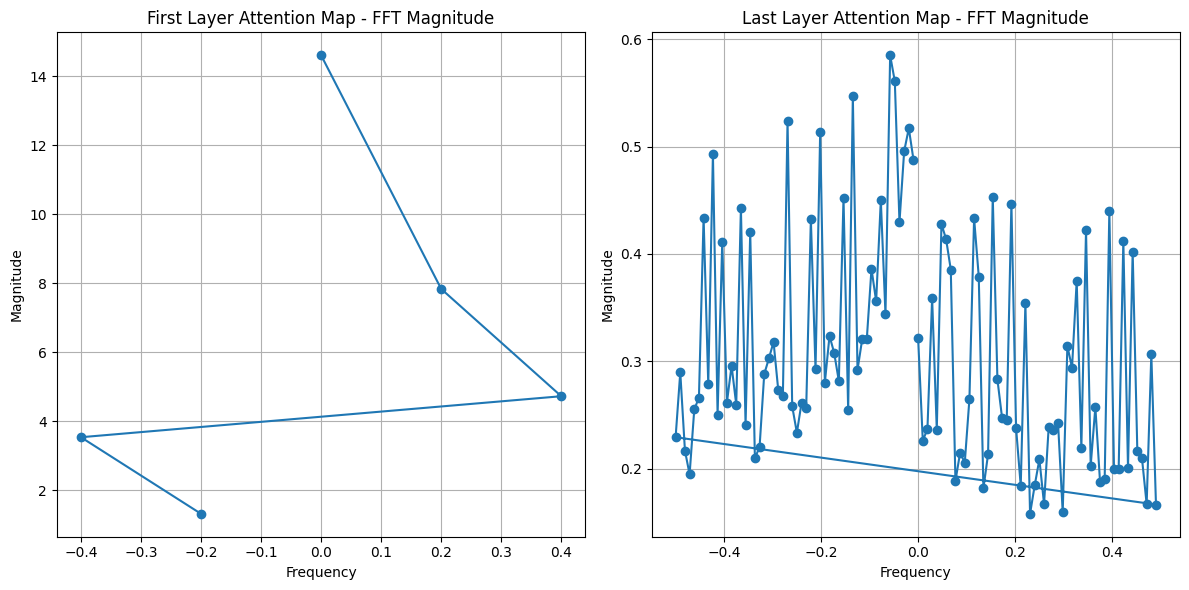

In [18]:
importlib.reload(visualizer)
visualizer.visualize_fft(attention_weights, in_layer=0, out_layer=-1, device=device, attention=True)

In [ ]:
import modified_llama
franken_llama = modified_llama.ModifiedLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, attn_implementation="eager")
franken_llama.to('cuda')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ModifiedLlamaForCausalLM(
  (model): ModifiedLlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
 

Llama2 has 32 decoder layers, each one of them representing a block in a transformer decoder.

Each LlamaDecoderLayer is made of an Attention block, a MLP and 2 RMSNorms.

### Visualizing attention maps
#### Layer 1
We're first going to visualize the first layer attention map, and we'll go deeper.
We're also just going to visualize the first head attention map, and as such we can expect the first token to get more focus compared to the others.

In [ ]:
layer_idx = 0
head_idx = 0

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
visualizer.plot_attention_map(outputs.attentions, tokens, layer_idx=layer_idx, head_idx=head_idx)

For the first layer, we can see how the model outputs a `SEQ_LENxSEQ_LEN` attention map. It's interesting how some the last tokens have some importance w.r.t to themselves.

In [ ]:
layer_idx = 20
head_idx = 0

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
visualizer.plot_attention_map(outputs.attentions, tokens, layer_idx=layer_idx, head_idx=head_idx)

Analyzing the tokens later becomes much more difficult, as the attention is computed only w.r.t. the final token of the generated sequence.

This is because Llama2, just like many other decoder only transformers, uses Masked Causal attention, which generates attention only for the last token in order to speed up computation.

Going deeper into the net, we can see how the attention map increases with a value of `layer_depth + seq_len`.

### ...finally, Franken-LLama!
There are many ways to achieve the goal of running Llama2 without some running some specific layers (or repeating the same layer multiple times).

For this reason, I've developed two ways of achieving our goal, which vary in complexity/attainment to the original Llama2 specification.

#### Using the from-the-ground-up classes

For the scope of this project, I've decided to develop 2 classes which allow us to use a single attention layer without doing the background operations that Llama2 does in its backend (such as computing a rotary embedding layer).

For this reason, the quality of the output is much lower, however the computation is faster. In addition, the attention maps cannot be analyzed. Nevertheless, it is a cool experiment and for that I think it's worthwhile.


In [ ]:
import llama_utils
importlib.reload(llama_utils)
test_model = llama_utils.SimpleLlamaSkipRepeat(franken_llama, layers_to_repeat=[], num_repeats=1, config=franken_llama.config, skip_all=False)

c:\Users\ASUS\Desktop\APAI-pw\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\ASUS\Desktop\APAI-pw\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [ ]:
output_res = test_model.generate(input_ids, max_new_tokens=20)
generated_ids = output_res.sequences
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("\n"+"-"*10)
print("GENERATED TEXT:", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
c:\Users\ASUS\Desktop\APAI-pw\.venv\Lib\site-packages\transformers\generation\utils.py:2097: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cuda, whereas the model is on <attribute 'type' of 'torch.device' objects>. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('<attribute 'type' of 'torch.device' objects>') before running `.generate()`.
  warnings.warn(


Once upon a time ...



 Unterscheidung ... upon a time ... upon ... upon ...


Generation is really, really poor, even without skipping any layer. This proves that the operations between each layer repetition are vital for a proper LLM model.

In [ ]:
output_res = test_model(input_ids, test_output=True)
token_ids = output_res.squeeze().tolist()
generated_text = tokenizer.decode(token_ids, skip_special_tokens=True)

In [ ]:
print(output_res)
print("\n"+"-"*10)
print("GENERATED TEXT:", generated_text)

tensor([[   13,  2501,   263, 23196,  2023]], device='cuda:0')

 upon a nobody ...


By running the phrase with each layer many times, it is interesting to see how the some of the semantic value of each word is somewhat retained, even after "digesting" the input multiple times.

However, using the same layer more than 5 times results in an "overdigested" output, that completely loses any significance.

#### Using the modified transformer classes

Like I mentioned, many of the operations required for Llama to work properly have been skipped in the previous version of the classes. The modified transformer classes represent an attempt to circumvent this issues by taking the source code of Llama2 and modifying it to skip or repeat some layers.

> :WARNING: In order to run these models properly, it is very much suggested to reload the python kernel to free up memory. For this reason, some imports will be repeated.


In [ ]:
import gc

# memory cleanup
del model
del test_model
gc.collect()

# restart the kernel
%reset -f

In [1]:
from transformers import AutoTokenizer
import modified_llama
import torch
import importlib
import visualizer
import IPython


model_name = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"

Note: the `set_frankenstein()` method was needed as setting the `config` object manually resulted in `torch.float16` in not being set properly, and as such the model causes CUDA to go out of memory.

In [ ]:
franken_llama = modified_llama.ModifiedLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, attn_implementation="eager")
franken_llama.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ModifiedLlamaForCausalLM(
  (model): ModifiedLlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x ModifiedLlamaDecoderLayer(
        (self_attn): ModifiedLlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=

In [ ]:
franken_llama.set_frankestein(layers_to_repeat=list(range(23, 32)), layers_to_skip=list(range(0, 23)), num_repeats=3, skip_all=False)
franken_llama.config.output_attentions = True
franken_llama.config.return_dict = True
franken_llama.config.output_hidden_states = True

input_text = "Once upon a time"
input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)

outputs = franken_llama.generate(input_ids, max_new_tokens=50, output_attentions=True, return_dict_in_generate=True, output_hidden_states=True)

generated_ids = outputs.sequences
attention_weights = outputs.attentions
states = outputs.hidden_states

generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
print("\n"+"-"*10)
print("GENERATED TEXT:", generated_text)

### Visualizing attention layers of the franken-Llama

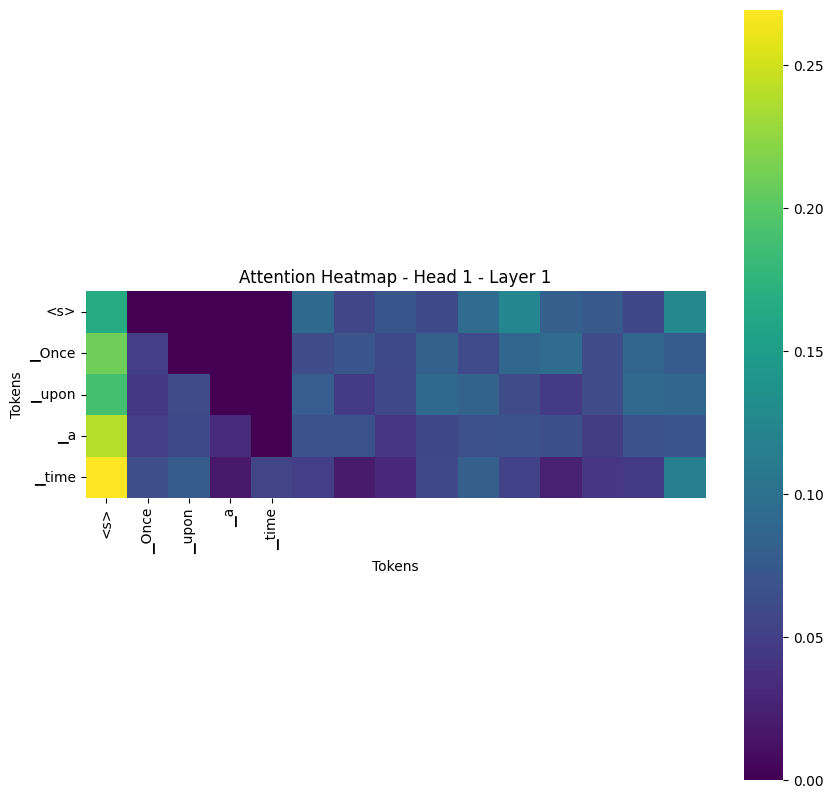

In [ ]:
layer_idx = 0
head_idx = 0

tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
visualizer.plot_attention_map(outputs.attentions, tokens, layer_idx=layer_idx, head_idx=head_idx)

The relatively dark coloring suggests that this head in Layer 1 does not emphasize specific attention at this stage but rather distributes attention broadly, which is common in the earlier layers of transformers to capture global context